# Ranking Algorithm P2
This document finalises our results

In [7]:
# libraries 
import sys
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import feature as H
from operator import add
from functools import reduce
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

In [8]:
def open_spark():
    # First lets reed the datasets
    spark = (
        SparkSession.builder.appName("Data_Explorer")
        .config("spark.sql.repl.eagerEval.enabled", True) 
        .config("spark.sql.parquet.cacheMetadata", "true")
        .config("spark.sql.session.timeZone", "Etc/UTC")
        .config("spark.driver.memory", "4g")
        .getOrCreate())
    return spark

In [9]:
spark = open_spark()

# NOTE: The value below can be changed to point to the directory where all the tables are stored. By default, it's the data folder in the generic-buy-now-pay-later directory.

dir = "../data/"

In [26]:
# This function is used to apply the minimising scoring process for a certain metric
# This time 0 [best] - 1 [worst]
def scroring_process(dataset):
    # first subtract 1 from each cell then square
    for col in dataset.columns[1:]:
        dataset = dataset.withColumn(col, F.pow((F.col(col) - 1),2))
    # sum the columns 
    dataset = dataset.withColumn('total',F.round(reduce(add, [F.col(x) for x in dataset.columns[1:]]), 8))
    return dataset

# Define our scaling transfomration function, resulting in attributes ranked within 0 [worst] - 1 [best]
def feature_standardisation(dataset): 
    values = dataset.select(F.max('total').alias('high'), F.min('total').alias('low'))
    dataset = dataset.withColumn('total', F.round((F.col('total') - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]), 9))
    return dataset.select('merchant_abn', 'total')

In [27]:
from queue import Full


def main():
    # Read all our tables 
    customer_scaled = spark.read.parquet(dir + 'curated/Metric_Customer_scaled')
    customer_scaled = customer_scaled.fillna(0.5)
    industry_scaled = spark.read.parquet(dir + 'curated/Metric_industry_scaled')
    industry_scaled = industry_scaled.fillna(0.5)
    # need to remove sector name and store in lookup 
    sector_lookup = industry_scaled.select('merchant_abn', 'sector')
    industry_scaled = industry_scaled.drop('sector')
    sustainability_scaled = spark.read.parquet(dir + 'curated/Metric_Sustainability_scaled')
    sustainability_scaled = sustainability_scaled.fillna(0.5)
    revenue_scaled = spark.read.parquet(dir + 'curated/Metric_Finantial_scaled')
    revenue_scaled = revenue_scaled.fillna(0.5)
    # score industry, then add to sustainability
    industry_scaled = scroring_process(industry_scaled)
    industry_scaled = industry_scaled.select('merchant_abn','total')
    industry_scaled = feature_standardisation(industry_scaled)
    industry_scaled = industry_scaled.withColumnRenamed('total','Industry_score')
    sustainability_scaled = sustainability_scaled.join(industry_scaled, on='merchant_abn', how='left')
    # Scale all metrics now
    customer_scaled = scroring_process(customer_scaled)
    sustainability_scaled = scroring_process(sustainability_scaled)
    revenue_scaled = scroring_process(revenue_scaled)
    # Now equally combine them to get the final merchant score 
    customer_scaled = customer_scaled.select('merchant_abn','total')
    customer_scaled = feature_standardisation(customer_scaled)
    customer_scaled = customer_scaled.withColumnRenamed('total','Customer_score')
    revenue_scaled = revenue_scaled.select('merchant_abn','total')
    revenue_scaled = feature_standardisation(revenue_scaled)
    revenue_scaled = revenue_scaled.withColumnRenamed('total','Revenue_score')
    sustainability_scaled = sustainability_scaled.select('merchant_abn','total')
    sustainability_scaled = feature_standardisation(sustainability_scaled)
    sustainability_scaled = sustainability_scaled.withColumnRenamed('total','Sustainability_score')
    # Finally join 
    Full_scores = customer_scaled.join(revenue_scaled, on='merchant_abn', how='inner').join(sustainability_scaled, on='merchant_abn', how='inner')
    Full_scores = Full_scores.withColumn('Merchant_score',F.round(reduce(add, [F.col(x) for x in Full_scores.columns[1:]]), 8))
    Full_scores = Full_scores.join(sector_lookup, on='merchant_abn', how='inner')

    # Add the rank column
    Full_scores = Full_scores.orderBy('Merchant_score').withColumn("Rank",F.monotonically_increasing_id() + 1)

    Full_scores.write.parquet(dir + 'curated/Merchant_Rankings', mode='overwrite')
    # now that we have saved the 'fat version' of our output, we will save for the outcomes 
    # Top 100
    merchant = spark.read.parquet(dir + 'processed/merchants/')
    Full_scores = Full_scores.join(merchant, on='merchant_abn')
    Full_scores.select('merchant_abn','name', 'Merchant_score', 'Rank').orderBy('Merchant_score').limit(100).write.parquet(dir + 'curated/Top_100_Merchants', mode='overwrite')
    # Top 10 per segment
    windowDept = Window.partitionBy("sector").orderBy(col("Merchant_score"))
    df2=Full_scores.withColumn("sector_rank",row_number().over(windowDept)).filter(col("sector_rank") <= 10)
    df2 = df2.select('sector','merchant_abn','name', 'Merchant_score', 'sector_rank')
    df2.write.parquet(dir + 'curated/Top_10_by_Segment', mode='overwrite')

In [28]:
main()

# Plotting 

In [ ]:
Ranking_Scores = spark.read.parquet(dir + 'curated/Merchant_Rankings')

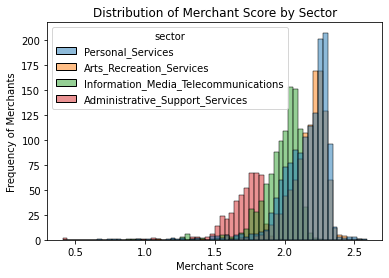

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
Ordered_data = Ranking_Scores.toPandas()
Ordered_data = Ordered_data.sort_values(by=['Merchant_score'], ascending=False)
palette ={"Personal_Services": "C0", "Arts_Recreation_Services": "C1", "Information_Media_Telecommunications": "C2", "Administrative_Support_Services":'C3'}
sns.histplot(x='Merchant_score', hue='sector', data=Ordered_data, palette=palette)
plt.title('Distribution of Merchant Score by Sector')
plt.xlabel('Merchant Score')
plt.ylabel('Frequency of Merchants')
plt.savefig(dir + '../plots/Distribution_of_Merchant_Score.png')

In [31]:
top_100 = Ranking_Scores.orderBy('Merchant_score').limit(100)
top_100_pd = top_100.groupBy('sector').count().toPandas() 

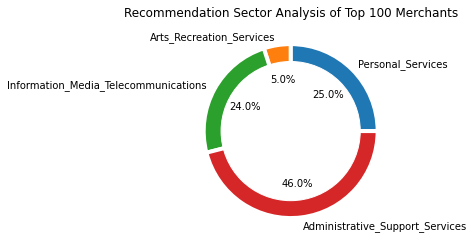

In [32]:
# library
import matplotlib.pyplot as plt
import seaborn as sns
# create data
names = ['Personal_Services', 'Arts_Recreation_Services', 'Information_Media_Telecommunications', 'Administrative_Support_Services']
size = [25,5,24,46]
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.8, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 4, 'edgecolor' : 'white' }, autopct="%.1f%%")
plt.title('Recommendation Sector Analysis of Top 100 Merchants')
p = plt.gcf()
p.gca().add_artist(my_circle)
p.savefig(dir + '../plots/Top_100_Pie.png')

# Now do the Bar plot 

# The following can be removed, once added to the pre_processing stage

In [33]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import pandas as pd
# This is used to standardise the description of each merchant
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)

# This function takes the pandas dataframe containing merchant information and pre_processes it
def merchant_process(merchants, spark):
    merchants = merchants.toPandas()
    # Lets process the tags
    tags = merchants['tags']
    processed_tags = []
    for i in tags:
        processed_tags.append(tag_extract(i))
    merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
    merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
    # drop the tags column 
    merchant_tbl.drop(columns='tags', inplace=True)
    merchant_tbl = spark.createDataFrame(merchant_tbl)
    return merchant_tbl

# End of additional Pre_processing

In [34]:
# Implement pre processing to merchant
from numpy import full


merchant = spark.read.parquet(dir + 'processed/merchants/')
merchant = merchant_process(merchant, spark)
# combine merchants and transactions
trans = spark.read.parquet(dir + 'processed/transactions/')
full_dataset = trans.join(merchant, on='merchant_abn', how='inner')
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))

In [35]:
# For top 600
top_600 = Ranking_Scores.orderBy('Merchant_score').limit(600)

In [36]:
trans100 = full_dataset.join(top_100, on='merchant_abn', how = 'inner')
trans600 = full_dataset.join(top_600, on='merchant_abn', how = 'inner')

In [37]:
# This assumes the unsued_functions in P1 have been implemented
revenue_100 = trans100.select(F.sum('BNPL_Revenue')).collect()[0][0]
revenue_600 = trans600.select(F.sum('BNPL_Revenue')).collect()[0][0] - revenue_100

Compare top 600 revenue 

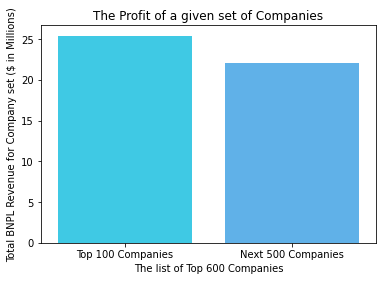

In [38]:
sns.barplot(x=['Top 100 Companies', 'Next 500 Companies'],y=[revenue_100 / 1000000, revenue_600 / 1000000], palette= sns.color_palette("cool"))
plt.title('The Profit of a given set of Companies')
plt.xlabel('The list of Top 600 Companies')
plt.ylabel('Total BNPL Revenue for Company set ($ in Millions)')
plt.savefig(dir + '../plots/Top_600_Revenue.png')

# Distribution of scores


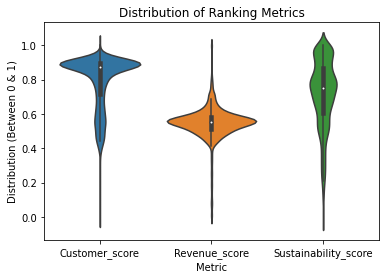

In [39]:
sns.violinplot(data=Ranking_Scores.select('Customer_score', 'Revenue_score', 'Sustainability_score').toPandas())
plt.title('Distribution of Ranking Metrics')
plt.xlabel('Metric')
plt.ylabel('Distribution (Between 0 & 1)')
plt.savefig(dir + '../plots/Metric_Score_Distributions.png')

# Top 10 (Unused)

In [40]:
top_100_pd = top_100.orderBy('Merchant_score').limit(10)

In [41]:
top_100_pd = top_100_pd.toPandas()

In [42]:
top_100_pd = top_100_pd.sort_values(by='Merchant_score')

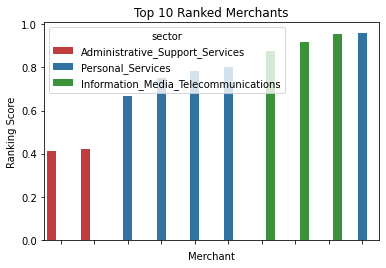

In [43]:
plot_order = top_100_pd.sort_values(by='Merchant_score').merchant_abn.values
plot = sns.barplot(x='merchant_abn', y='Merchant_score', hue='sector', data=top_100_pd, order=plot_order, palette=palette)
plot.set(xticklabels=[])
plot.set(title='Top 10 Ranked Merchants')
plot.set(xlabel='Merchant')
plot.set(ylabel='Ranking Score')
fig = plot.get_figure()
fig.savefig(dir + '../plots/Top_10_Ranked_Merchants')